In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    cross_val_score,
    cross_val_predict
)

In [2]:
def get_region_list(base_path):
    return sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
           and not d.startswith('all_models')
           and not d.startswith('hcp')
           and not d.startswith('ukb')
           and not d.endswith('.csv')
           and not d.endswith('.sh')
           and not d.endswith('embeddings')
    ])

In [3]:
# CONFIG
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/csv_cognition_abcd/nc_y_nihtb.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"

scores = [
 'nihtbx_flanker_agecorrected',
 'nihtbx_cardsort_agecorrected',
 'nihtbx_list_agecorrected',
 'nihtbx_pattern_agecorrected',
 'nihtbx_picvocab_agecorrected',
 'nihtbx_reading_agecorrected',
 'nihtbx_fluidcomp_agecorrected',
 'nihtbx_cryst_agecorrected',
 'nihtbx_totalcomp_agecorrected'
]

labels_df = pd.read_csv(labels_path)
print(labels_df.shape)
labels_df = labels_df[labels_df["eventname"] == "baseline_year_1_arm_1"]
print(labels_df.shape)

existing_scores = [s for s in scores if s in labels_df.columns]
cols = ["src_subject_id"] + existing_scores
labels_df = labels_df[cols]
print(labels_df.index)

regions = get_region_list(os.path.join(base_path,"../.."))
regions.remove("params_OLS")
regions.remove("region_list")
regions.remove("analysis")
#regions = ["STs_right","FCLp-subsc-FCLa-INSULA_right","FCMpost-SpC_right","STi-STs-STpol_right"]
#region = regions[0]

labels_df['src_subject_id'] = (
    labels_df['src_subject_id'].astype(str)
    .str.replace(r"^sub-", "", regex=True)
    .str.replace("_", "", regex=False)
)

df_ages = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/prematurity_labels_true_classes.csv")


/tmp/ipykernel_1449589/2849965271.py:17: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  labels_df = pd.read_csv(labels_path)


(27028, 120)
(11727, 120)
Index([    0,     1,     3,     5,     7,    10,    13,    15,    18,    20,
       ...
       27001, 27003, 27006, 27008, 27010, 27012, 27015, 27018, 27021, 27024],
      dtype='int64', length=11727)


In [4]:
def load_embeddings(region):
    
    for file in os.listdir(base_path):
            if file.startswith(region) and file.endswith(".csv"):
                embedding_file = file
                break
            
    if embedding_file is None:
        raise FileNotFoundError(f"No embedding file found for region: {region}")

    print(f"Using embedding file: {embedding_file}")

    emb_path = os.path.join(base_path, embedding_file)
    emb_df = pd.read_csv(emb_path)
    emb_df['ID_clean'] = (
        emb_df['ID'].astype(str)
        .str.replace(r"^sub-", "", regex=True)
        .str.replace("_", "", regex=False)
    )
    return emb_df
    

In [5]:
def preprocess_data(df,prem_class,score):
    
    df_with_cognition = df.merge(
        labels_df,
        left_on='ID_clean', right_on='src_subject_id', how='inner'
    )
    df_with_cognition_and_ages= df_with_cognition.merge(df_ages, left_on='src_subject_id', right_on='src_subject_id', how='inner')
    print(df.columns)
    df_with_cognition_and_ages= df_with_cognition_and_ages[df_with_cognition_and_ages["prem_class"].isin(prem_class)]
    print("test",df_with_cognition_and_ages.shape)

    df_with_cognition_and_ages['y'] = df_with_cognition_and_ages[score]
    df_with_cognition_and_ages.dropna(subset=[score], inplace=True)

    X = df_with_cognition_and_ages.filter(regex=r'^dim').values
    y = df_with_cognition_and_ages['y'].values
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

    return X, y
    


In [7]:
def regress_on_cognition(score,region,prem_class):
   
    emb_df = load_embeddings(region)
    X,y = preprocess_data(emb_df, prem_class, score)


    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor',Ridge())
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        pipe, {'regressor__alpha': [0.01, 0.1, 1, 10]},
        cv=cv, scoring='r2', n_jobs=-1
    )
    grid.fit(X, y)
    best_C = grid.best_params_['regressor__alpha']
    cv_scores = cross_val_score(grid, X, y,
                                cv=cv, scoring='r2', n_jobs=-1)
    print(f"Results for region {region} and score {score}:")
    print(cv_scores.mean(), cv_scores.std())

    # cross-validated predictions for pearson
    y_pred = cross_val_predict(grid, X, y, cv=cv, n_jobs=-1)
    try:
        r, p = pearsonr(y, y_pred)
    except Exception:
        r, p = np.nan, np.nan

    print("Pearson r(pred, true):", r, "p:", p)

    return {
        "region": region,
        "score": score,
        "n": len(y),
        "best_alpha": best_C,
        "r2_mean": cv_scores.mean(),
        "r2_std": cv_scores.std(),
        "pearson_r": r,
        "pearson_p": p
    }


In [8]:
results = []
out_path = "cognitive_correlations_prema_clean.csv"
for region in regions:
    for score in existing_scores:
        result = regress_on_cognition(score, region,["28-32","32-37"])
        results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv(out_path, index=False)

Using embedding file: CINGULATE_left_name17-24-32--191_embeddings.csv
Index(['ID', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8',
       'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16',
       'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24',
       'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32',
       'ID_clean'],
      dtype='object')
test (1287, 48)
Shape of X: (1287, 32), Shape of y: (1287,)
Results for region CINGULATE_left and score nihtbx_flanker_agecorrected:
-0.02584543586932677 0.03281197368763081
Pearson r(pred, true): 0.03744476456371061 p: 0.17943772478392683
Using embedding file: CINGULATE_left_name17-24-32--191_embeddings.csv
Index(['ID', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8',
       'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16',
       'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24',
       'dim25', 'dim26', 'dim27

In [101]:
results = []
out_path = "cognitive_correlations_all_regions_fullterms.csv"
for region in regions:
    for score in existing_scores:
        result = regress_on_cognition(score, region,[">=37"])
        results.append(result)

results_df = pd.DataFrame(results)
results_df.to_csv(out_path, index=False)

Using embedding file: CINGULATE_left_name17-24-32--191_embeddings.csv
Index(['ID', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8',
       'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16',
       'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24',
       'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32',
       'ID_clean'],
      dtype='object')
test (8532, 48)
Shape of X: (8521, 32), Shape of y: (8521,)
Results for region CINGULATE_left and score nihtbx_flanker_agecorrected:
-0.0016445626686187875 0.003847131766713353
Pearson r(pred, true): 0.035241689769302954 p: 0.001139254321334292
Using embedding file: CINGULATE_left_name17-24-32--191_embeddings.csv
Index(['ID', 'dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8',
       'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16',
       'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24',
       'dim25', 'dim26', '

In [11]:
corr = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/cognitive_correlations_fullterms_clean.csv")
corr.sort_values(by=["pearson_r"], inplace=True, ascending=False)
print(corr.head(20)[["region","score","pearson_r","r2_mean"]])

                           region                          score  pearson_r  \
67                FColl-SRh_right   nihtbx_picvocab_agecorrected   0.193260   
409              STi-SOTlat_right   nihtbx_picvocab_agecorrected   0.192719   
400               STi-SOTlat_left   nihtbx_picvocab_agecorrected   0.184953   
413              STi-SOTlat_right  nihtbx_totalcomp_agecorrected   0.180452   
58                 FColl-SRh_left   nihtbx_picvocab_agecorrected   0.180183   
71                FColl-SRh_right  nihtbx_totalcomp_agecorrected   0.179094   
70                FColl-SRh_right      nihtbx_cryst_agecorrected   0.178524   
62                 FColl-SRh_left  nihtbx_totalcomp_agecorrected   0.176967   
404               STi-SOTlat_left  nihtbx_totalcomp_agecorrected   0.172545   
412              STi-SOTlat_right      nihtbx_cryst_agecorrected   0.170879   
403               STi-SOTlat_left      nihtbx_cryst_agecorrected   0.168731   
61                 FColl-SRh_left      nihtbx_cryst_

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
terms_csv  = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/cognitive_correlations_fullterms_clean.csv"
prem_csv   = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/cognitive_correlations_prema_clean.csv"
out_csv    = "fisher_comparison_terms_vs_premas_clean.csv"

# charge
df_terms = pd.read_csv(terms_csv)
df_prem  = pd.read_csv(prem_csv)

# normalise les noms (optionnel, assure matching exact)
def key_col(df):
    return df['region'].astype(str) + "||" + df['score'].astype(str)

df_terms['key'] = key_col(df_terms)
df_prem['key']  = key_col(df_prem)

# merge
df = pd.merge(df_terms, df_prem, on='key', suffixes=('_term','_prema'))
# extrait region/score
df['region'] = df['region_term']
df['score']  = df['score_term']

# fonction Fisher z test (two-sided)
def fisher_z_test(r1, n1, r2, n2):
    # handle edge cases: clip r to (-0.999999, 0.999999)
    r1 = np.clip(r1, -0.999999, 0.999999)
    r2 = np.clip(r2, -0.999999, 0.999999)
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z = (z1 - z2) / se
    p_two = 2 * (1 - norm.cdf(abs(z)))
    cohen_q = z1 - z2  # also sometimes reported as q = atanh(r1)-atanh(r2)
    return z, p_two, cohen_q

# compute
res = []
for _, row in df.iterrows():
    r_term = float(row['pearson_r_term'])
    n_term = int(row['n_term'])
    r_pre  = float(row['pearson_r_prema'])
    n_pre  = int(row['n_prema'])
    z, p, q = fisher_z_test(r_pre, n_pre, r_term, n_term)  # pre vs term
    res.append({
        'region': row['region'],
        'score': row['score'],
        'r_term': r_term,
        'n_term': n_term,
        'r_prema': r_pre,
        'n_prema': n_pre,
        'fisher_z': z,
        'p_fisher': p,
        'cohen_q': q
    })

res_df = pd.DataFrame(res)

# correction multiple tests (FDR)
reject, pvals_corr, _, _ = multipletests(res_df['p_fisher'].values, method='fdr_bh')
res_df['p_fisher_fdr'] = pvals_corr
res_df['p_fisher_fdr_reject'] = reject

# sauvegarde
res_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: fisher_comparison_terms_vs_premas_clean.csv



=== Top 10 où les corrélations sont plus fortes chez les TERMES ===
                          region                          score    r_term  \
102          FPO-SCu-ScCal_right    nihtbx_pattern_agecorrected  0.033088   
46             FCMpost-SpC_right   nihtbx_cardsort_agecorrected  0.006972   
436                     STs_left   nihtbx_picvocab_agecorrected  0.151963   
159              OCCIPITAL_right  nihtbx_fluidcomp_agecorrected  0.067133   
87                     FIP_right  nihtbx_fluidcomp_agecorrected  0.057095   
330                SOr-SOlf_left  nihtbx_fluidcomp_agecorrected  0.092901   
359                    SOr_right  nihtbx_totalcomp_agecorrected  0.109083   
313  SFmedian-SFpoltr-SFsup_left      nihtbx_cryst_agecorrected  0.104261   
350                     SOr_left  nihtbx_totalcomp_agecorrected  0.145080   
153              OCCIPITAL_right    nihtbx_flanker_agecorrected  0.047914   

      r_prema   cohen_q  p_fisher_fdr  
102  0.142655  0.110535      0.010370  
46 

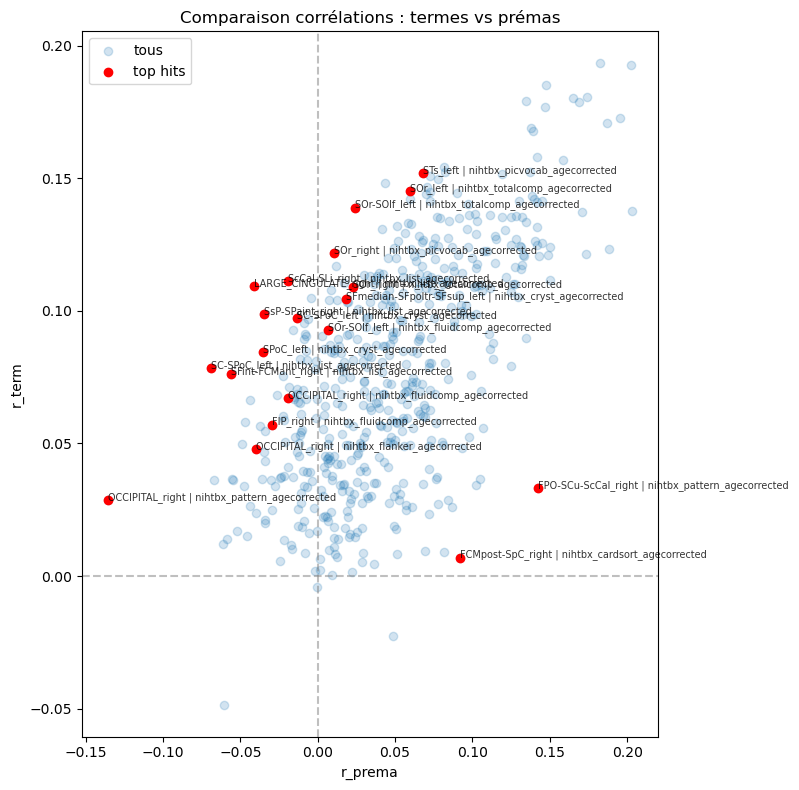

In [16]:
csv_out = "fisher_top_hits_summary.csv"
plot_out = "fisher_scatter_top_hits.png"

df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/fisher_comparison_terms_vs_premas_clean.csv")

# only significant results
sig = df[df["p_fisher_fdr_reject"] == True]

# order by cohen_q
top_pos = sig.sort_values(by="cohen_q", ascending=False).head(10)

# order by cohen_q (negative)
top_neg = sig.sort_values(by="cohen_q", ascending=True).head(10)

print("\n=== Top 10 où les corrélations sont plus fortes chez les TERMES ===")
print(top_pos[["region","score","r_term","r_prema","cohen_q","p_fisher_fdr"]])

print("\n=== Top 10 où les corrélations sont plus fortes chez les PREMATURÉS ===")
print(top_neg[["region","score","r_term","r_prema","cohen_q","p_fisher_fdr"]])

# concat top
top_hits = pd.concat([top_pos, top_neg])

# sauvegarde CSV résumé
top_hits.to_csv(csv_out, index=False)

print(f"Sauvegardé : {csv_out}")

# === scatterplot ===
plt.figure(figsize=(8,8))
plt.axhline(0, color="grey", linestyle="--", alpha=0.5)
plt.axvline(0, color="grey", linestyle="--", alpha=0.5)

plt.scatter(df["r_prema"], df["r_term"], alpha=0.2, label="tous")
plt.scatter(top_hits["r_prema"], top_hits["r_term"], color="red", label="top hits")

# annotation des points top
for _, row in top_hits.iterrows():
    label = f"{row['region']} | {row['score']}"
    plt.annotate(label, (row["r_prema"], row["r_term"]), fontsize=7, alpha=0.8)

plt.xlabel("r_prema")
plt.ylabel("r_term")
plt.title("Comparaison corrélations : termes vs prémas")
plt.legend()
plt.tight_layout()
plt.savefig(plot_out, dpi=300)
print(f"Sauvegardé : {plot_out}")
plt.show()
